In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import pylab as pl
from IPython.display import clear_output

from src import *

from src.BitDiffusion import *

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
device = torch.device("cpu")

In [6]:
file="models/diffusion_no_collapse_k=0.7.pt"
loaded=torch.load(file,map_location=device)
torch.save(loaded.state_dict(), 'asd.pt')

param=loaded.param
model = Unet(
    dim = param["Unet_dim"],
    channels = param["channels"],
    dim_mults = (1, 2, 4, 8),
    bits = BITS,
).to(device)

diffusion = BitDiffusion(model, image_size = 32, collapsing=param["collapsing"], schedule_function=cosine_schedule).to(device)
#diffusion.schedule=cosine_schedule
#diffusion.losses = []
diffusion.timesteps=100

diffusion.load_state_dict(torch.load("asd.pt"))

batch_size=param['batch_size']
k=param['k']

In [7]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

max_cross=param["max_cross"]
def cross_entropy(prediction, target, max_cross=max_cross):
    ce= target*torch.log2(prediction + 1e-8) + (1-target)*torch.log2(1-prediction + 1e-8)
    ce=torch.tanh(ce/max_cross)*max_cross
    return -torch.mean(ce)

def loss_function(predictions, target, max_cross=max_cross):
    target=target+.5
    predictions=predictions+.5
    probabilities=torch.sin(predictions*np.pi/2)**2
    return cross_entropy(probabilities,target, max_cross)

Files already downloaded and verified


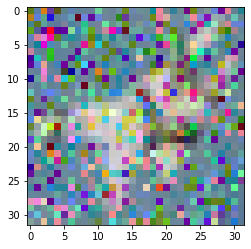

In [13]:
images = decimal_to_qubits(testset[10][0].unsqueeze(0),bits=BITS)
t=diffusion.timesteps//10

alpha=diffusion.schedule(t)*torch.ones(len(images))

noised_images = gaussian_noise(images, alpha, k)
imshow(qubit_to_decimal(noised_images))


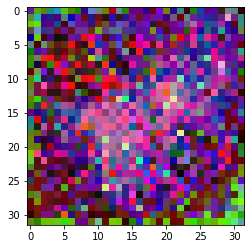

In [54]:
noise_level=probablity_flip_gaussian(alpha, k)
y=[]
out=diffusion(noised_images,noise_level)

for i in np.logspace(-2,2,100):
    out=diffusion(noised_images,noise_level*i)
    y.append(loss_function(out,images).detach().numpy())
#out=diffusion(out,noise_level*2)


imshow(qubit_to_decimal(out))


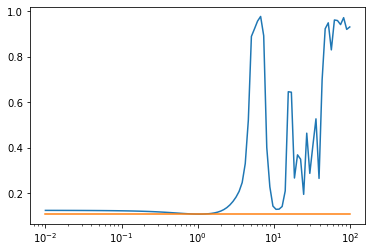

: 

In [55]:
out=diffusion(noised_images,noise_level)
plt.plot(np.logspace(-2,2,100),y)
plt.plot([10**-2,10**2],[loss_function(out,images).detach().numpy(),loss_function(out,images).detach().numpy()])
plt.xscale('log')

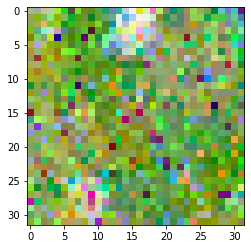

In [46]:
sample=diffusion.sample((1,24,32,32), k, timesteps=100)
sample=qubit_to_decimal(sample)
imshow(sample)

In [25]:
from src.utils import default, qubit_collapse, BITS
from src.diffusion_utils import denoise_images, generate_from_noise, linear_schedule, reverse_DDIM
from random import random

import torch
from torch import nn


from typing import Callable


class BitDiffusion(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        *,  # ma a che serve sto asterisco?
        image_size,
        schedule: Callable=linear_schedule,
        timesteps: int=1000,
        reverse_step: Callable=reverse_DDIM,
        collapsing: bool=True,
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels

        self.image_size = image_size
        self.schedule = schedule
        self.timesteps = timesteps
        self.collapsing = collapsing
        self.reverse_step = reverse_step

    @property #is this useful?
    def device(self):
        return next(self.model.parameters()).device

    @torch.no_grad()
    def sample(self, shape, k,  timesteps=None):
        """Generates an image from pure noise

        Args:
            shape (torch.Tensor): the shape of the images to generate. (b,c,h,w)
            device (torch.device, optional): _description_. Defaults to None.

        Returns:
            torch.Tensor: the generated images
        """
        assert len(shape) == 4, f'the images should have the four dimentions b,c,h,w, instead it has {len(shape)}'
        assert shape[1] == 3*BITS, f'channels must be {3*BITS}' #TODO: controllare che sia corretto

        timesteps=default(timesteps,self.timesteps)
        return generate_from_noise(self.model,self.reverse_step, shape, timesteps, self.schedule, self.device, k, self.collapsing)

    #WIP
    @torch.no_grad()
    def denoise(self, images, k, time=None, timesteps=None):
        assert len(images.shape) == 4, f'the images should have the four dimentions b,c,h,w, instead it has {len(images.shape)}'
        assert images.shape[1] == 3*BITS, f'channels must be {3*BITS}' #TODO: controllare che sia corretto

        timesteps=default(timesteps,self.timesteps)
        time = default(time, timesteps)
        return denoise_images(self.model, self.reverse_step, images, time, timesteps, self.schedule, k, self.collapsing)


    def forward(self, img:torch.Tensor,
                noise_level:torch.Tensor,
                self_conditioning:bool = False,
                *args, **kwargs) -> torch.Tensor:
        """This is an estiamate of the target image

        Args:
            img (torch.Tensor): the image to do the prediction of the target image
            noise (torch.Tensor): noise applied to each image. It can be calculated with probability_flip_gaussian()
            self_conditioning (bool, optional): wether or not to applu the self-conditioning to the algorithm. Defaults to False.

        Returns:
            torch.Tensor: The predition of the target image
        """

        _, _, h, w, img_size, = *img.shape, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'

        cond_img = None
        if self_conditioning and random() < 0.5:
            with torch.no_grad(): #testare dopo con il gradiente
                cond_img = self.model(img, noise_level).detach_()
                if self.collapsing: cond_img=qubit_collapse(cond_img)

        # predict
        pred = self.model(img, noise_level, cond_img)
        
        return pred



In [27]:
from src.utils import probablity_flip_gaussian, bmult, qubit_collapse, BITS
import numpy as np

import torch




#this part is to add noise
def bernoulli_noise(img:torch.Tensor, alpha:torch.Tensor, k:float=1) -> torch.Tensor:
    """takes a batch of images and adds to each one of them a bernoulli noise.
        The Bernulli noise can be applied only if the img is in the bit-wise representation
    Args:
        img (torch.Tensor): images to add noise to
        alpha (torch.Tensor): the sqrt(1-alpha) is the variance of the gaussian noise
        k (float): it is a parameter that changes the way the gaussian noise id added. Defaults to 1. 

    Returns:
        torch.Tensor: The noised images
    """
    assert alpha.shape[0]==img.shape[0], f'alpha must have the same size as the batch size of img, alpha has {alpha.shape[0]} and img has {img.shape[0]}'
    assert img.dtype==torch.bool, f'img must be in the bit-wise representation, img has dtype {img.dtype}'

    p_flip=probablity_flip_gaussian(alpha, k)

    bernulli_prob = bmult(p_flip, torch.ones_like(img))
    noise = torch.bernoulli(bernulli_prob).bool()

    return img ^ noise

def gaussian_noise(img:torch.Tensor, alpha:torch.Tensor, k:float=1):
    """Takes a batch of images and adds to each one of them a gaussian.
        The gaussian noise can be applied only if the img is in the qubit representation
    Args:
        img (torch.Tensor): images to add noise to
        alpha (torch.Tensor): the sqrt(1-alpha) is the variance of the gaussian noise
        k (float): it is a parameter that changes the way the gaussian noise id added. Defaults to 1. 

    Returns:
        torch.Tensor: The noised images
    """
    assert alpha.shape[0]==img.shape[0], f'alpha must have the same size as the batch size of img, alpha has {alpha.shape[0]} and img has {img.shape[0]}'
    assert img.dtype == torch.float, f'img must be in the qubit representation, img has dtype {img.dtype}'

    mu, sigma = torch.sqrt(alpha), torch.sqrt(1-alpha)*k

    noise = torch.randn_like(img).to(img.device)
    while torch.any(torch.isnan(noise)):
        noise = torch.randn_like(img).to(img.device)

    #       x*sqrt(alpha) + noise*sqrt(1-alpha)
    return bmult(mu, img) + bmult(sigma, noise)


#This part is for the scheduling of the alphas
#TODO: check if this function is consistend with the reverse step definition
def linear_schedule(t:float ,t_max:float, bits=BITS):
    """Calculates the alpha value for a given timestep, see eq. 17 of improved DDPM paper

    Args:
        t (float): current timestep
        t_max (float): total number of timesteps

    Returns:
        float: alpha value
    """

    s=1/bits

    return (t/t_max+s)/(1+s)

#TODO: check if this function is consistend with the reverse step definition
def cosine_schedule(t:float ,t_max:float, bits=BITS):
    """Calculates the alpha value for a given timestep, see eq. 17 of improved DDPM paper

    Args:
        t (float): current timestep
        t_max (float): total number of timesteps

    Returns:
        float: alpha value
    """

    s=1/bits

    #TODO: check if using the torch implementation for the cosine function is better
    return np.cos((t/t_max+s)/(1+s)*np.pi/2)**2









#this part is for the denoising
def denoise_images(model, reverse_step_function, x, time, timesteps, schedule, k, collapsing) -> torch.Tensor:
    """Generates an image from pure noise

    Args:
        model (nn.Module): the model to use for generation
        x (torch.Tensor): the images to denoise (b,c,h,w) 
            the first dimention is the batch
            the second dimention represents the channels, it must be equal to 3*BITS
            the third and fourth dimention represent the height and width of the image
        time (float): the current timestep
        timesteps (float): the number of total timesteps to count
        schedule (Callable): the function to use for the scheduling of the alphas
        k (float): it is a parameter that changes the way the gaussian noise id added
        collapsing (bool): if True then the qubits are collapsed after each timestep
    Returns:
        torch.Tensor: The generated images
    """
    #TODO: check the last step
    alpha_next=schedule(time,timesteps)*torch.ones(len(x)).to(x.device)
    for t in range(time,0,-1):
        noise_level=probablity_flip_gaussian(alpha_next, k)
        x_0=model(x,noise_level)

        alpha_old=alpha_next
        alpha_next=schedule(t,timesteps)*torch.ones(len(x)).to(x.device)

        x=reverse_step_function(x, x_0, alpha_old, alpha_next)
        
        if collapsing: x=qubit_collapse(x)

    return x

# Utils for diffusion
def generate_from_noise(model, reverse_step_function, shape, timesteps, schedule, device, k, collapsing) -> torch.Tensor:
    """Generates an image from pure noise

    Args:
        model (nn.Module): the model to use for generation
        reverse_step_function (Callable): the function to use for the reverse step
        shape (float): the shape of the tensor to generate. (b,c,h,w)
            the first dimention is the batch
            the second dimention represents the channels, it must be equal to 3*BITS
            the third and fourth dimention represent the height and width of the image
        timesteps (float): the number of total timesteps to count
        schedule (Callable): the function to use for the scheduling of the alphas
        device (torch.Device): the device to use
        k (float): it is a parameter that changes the way the gaussian noise id added
        collapsing (bool): if True then the qubits are collapsed after each timestep
    Returns:
        torch.Tensor: The generated images
    """

    x=torch.poisson(0.5*torch.ones(shape)).to(device).float() - 0.5
    return denoise_images(model, reverse_step_function, x, timesteps, timesteps, schedule, k, collapsing)



#this part defines the reverse step
def reverse_step(x: torch.tensor, x_0:torch.tensor, alpha_old:float, alpha_next:float, sigma:float) -> torch.Tensor:
    """Does the reverse step, you must calculate the epsilon separatelly. It implements eq 12 of the DDIM paper

    Args:
        x (torch.tensor): current state of the image
        x_0 (torch.tensor): prediction of the original image
        alpha_old (float): see eq 12 of DDIM paper
        alpha_next (float): see eq 12 of DDIM paper
        sigma (int or torch.Tensor, optional): Noise of the reverse step,
            if sigma = 0 then it is a DDIM step,
            if sigma = sqrt((1-alpha_old)/alpha_old) then it is a DDPM step.
            Defaults to 0.

    Returns:
        torch.Tensor: reverse step
    """
    mean=bmult(torch.sqrt(alpha_next),x_0)
    
    dx=x-bmult(torch.sqrt(alpha_old),x_0)
    const=torch.sqrt((1-sigma**2-alpha_next)/(1-alpha_old))
    
    mean+=bmult(const,dx)

    #      mean + normal(mean=0,std=sigma, size=x.shape)
    return mean + bmult(sigma, torch.normal(0, 1, size=x.shape, device=x.device))


def reverse_DDIM(x: torch.tensor, x_0:torch.tensor, alpha_old:float, alpha_next:float) -> torch.Tensor:
    """Calculates the reverse step. It implements eq 12 of the DDIM paper

    Args:
        x (torch.tensor): current state of the image
        x_0 (torch.tensor): prediction of the original image
        alpha_old (float): see eq 12 of DDIM paper
        alpha_next (float): see eq 12 of DDIM paper

    Returns:
        torch.Tensor: reverse step
    """
    return reverse_step(x,x_0,alpha_old,alpha_next,0)

def reverse_DDPM(x: torch.tensor, x_0:torch.tensor, alpha_old:float, alpha_next:float) -> torch.Tensor:
    """Calculates the reverse step. It implements eq 12 of the DDIM paper

    Args:
        x (torch.tensor): current state of the image
        x_0 (torch.tensor): prediction of the original image
        alpha_old (float): see eq 12 of DDIM paper
        alpha_next (float): see eq 12 of DDIM paper

    Returns:
        torch.Tensor: reverse step
    """
    sigma=torch.sqrt((1-alpha_old)/alpha_old)
    return reverse_step(x,x_0,alpha_old,alpha_next,sigma)